In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19

In [2]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [3]:
sites = {
    "SO2",
    "ES-LTERA",
    "FR-LAM",
}
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 6816
Num validation 1461
Num test 1461


In [4]:
# Compute data mean and std for channels
train_patches.set_transform(lambda x, y: (x[:3, :, :], y[:3, :, :]))
loader = DataLoader(train_patches, batch_size=256)
channel_means = torch.zeros((3, 1, 1))
channel_std = torch.zeros((3, 1, 1))
hr_channel_means = torch.zeros((3, 1, 1))
hr_channel_std = torch.zeros((3, 1, 1))

for low_res, high_res in loader:
    channel_means += torch.mean(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    channel_std += torch.std(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_means += torch.mean(high_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_std += torch.std(high_res, (0, 2, 3), keepdim=True).squeeze(0)

channel_means /= len(loader)
channel_std /= len(loader)
hr_channel_means /= len(loader)
hr_channel_std /= len(loader)

In [5]:
channel_means, hr_channel_means

(tensor([[[0.0498]],
 
         [[0.0775]],
 
         [[0.0824]]]),
 tensor([[[0.0500]],
 
         [[0.0778]],
 
         [[0.0826]]]))

In [6]:
channel_std, hr_channel_std

(tensor([[[0.0289]],
 
         [[0.0367]],
 
         [[0.0548]]]),
 tensor([[[0.0285]],
 
         [[0.0361]],
 
         [[0.0544]]]))

In [7]:
# def image_transform(x, y):
#     x = x[:3, :, :]
#     y = y[:3, :, :]
#     x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
#     x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)
#     y_channel_max = y.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
#     y_channel_min = y.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

#     x = (x - x_channel_min) / (x_channel_max - x_channel_min)
#     y = (y - y_channel_min) / (y_channel_max - y_channel_min)

#     return x, y


def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = (x - channel_means) / channel_std
    # y = (y - hr_channel_means) / hr_channel_std

    return x, y

In [8]:
train_patches.set_transform(image_transform)

In [9]:
train_loader = DataLoader(train_patches, batch_size=2)

In [10]:
(low_res, high_res) = next(train_loader.__iter__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


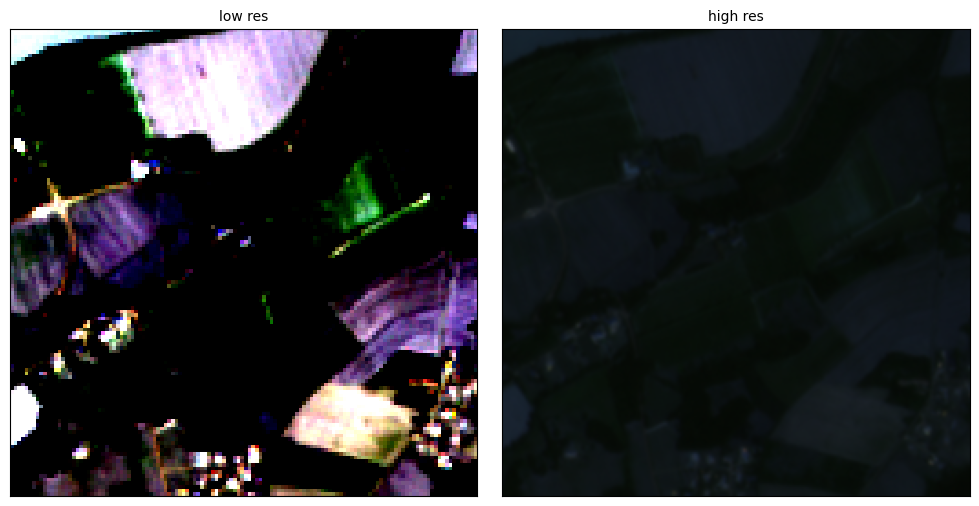

In [11]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [ ]:
# For clearing GPU memory
1 / 0

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [13]:
device

device(type='cuda')

In [14]:
model = SRResNet(scaling_factor=2, n_blocks=4)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

In [62]:
model = model.to(device)
model = model.train()

In [17]:
vgg = TruncatedVGG19().to(device)
vgg = vgg.eval()
vgg = vgg.requires_grad_(False)

In [63]:
NUM_EPOCHS = 100

In [19]:
losses = []
epoch_losses = []

In [64]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    epoch_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch)
        low_vgg = vgg(out)
        high_vgg = vgg(high_res_batch).detach()
        loss = criterion(low_vgg, high_vgg)
        # loss = criterion(out, high_res_batch)
        loss.backward()
        optimizer.step()

        # Collect data
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix(epoch=epoch, batch_loss=loss.item())

    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch: {epoch} / loss: {epoch_loss:.5f}")

  0%|                                  | 1/426 [00:01<09:24,  1.33s/it, batch_loss=0.00157, epoch=0]

In [55]:
len(epoch_losses)

59

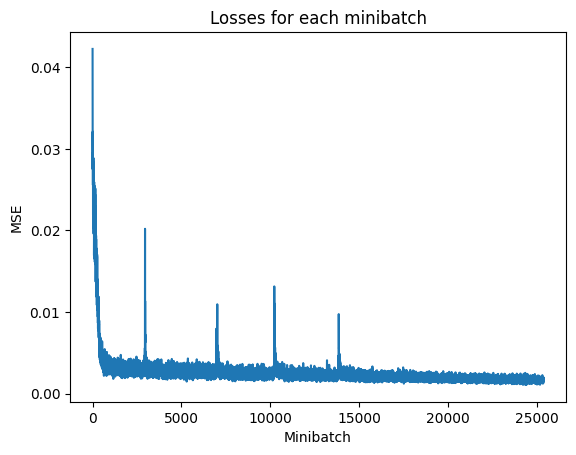

In [56]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()

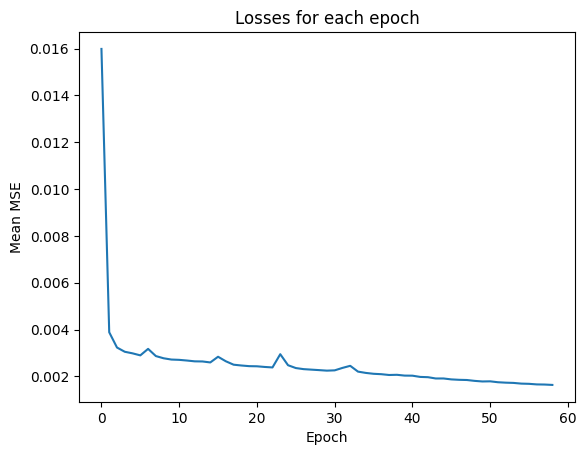

In [57]:
plt.plot(epoch_losses)
plt.title("Losses for each epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.show()

In [42]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
save_file = RESULTS_DIR / "superres300epochs_results.pkl"

In [58]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

In [59]:
model = model.to("cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


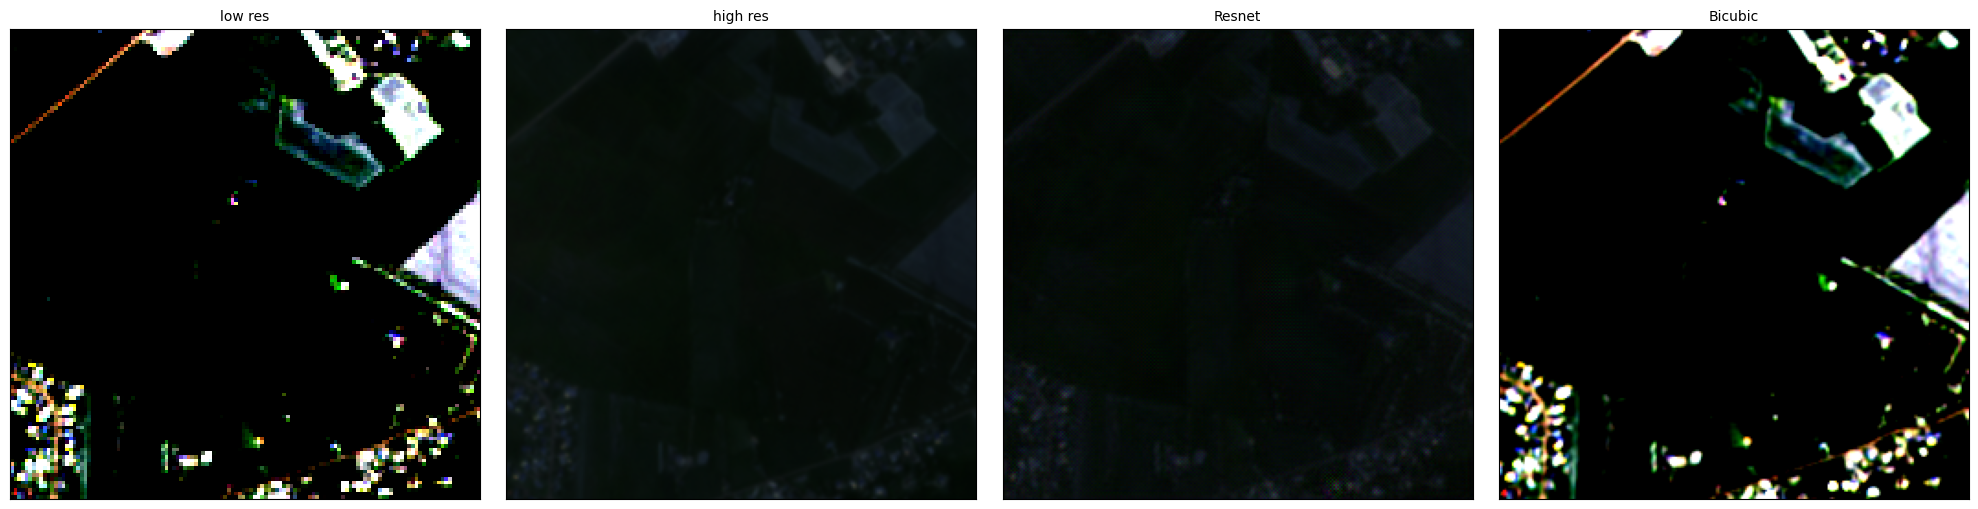

In [61]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
bicubic_out = interpolate(
    low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic"
).float()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
        bicubic_out[0].permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [48]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


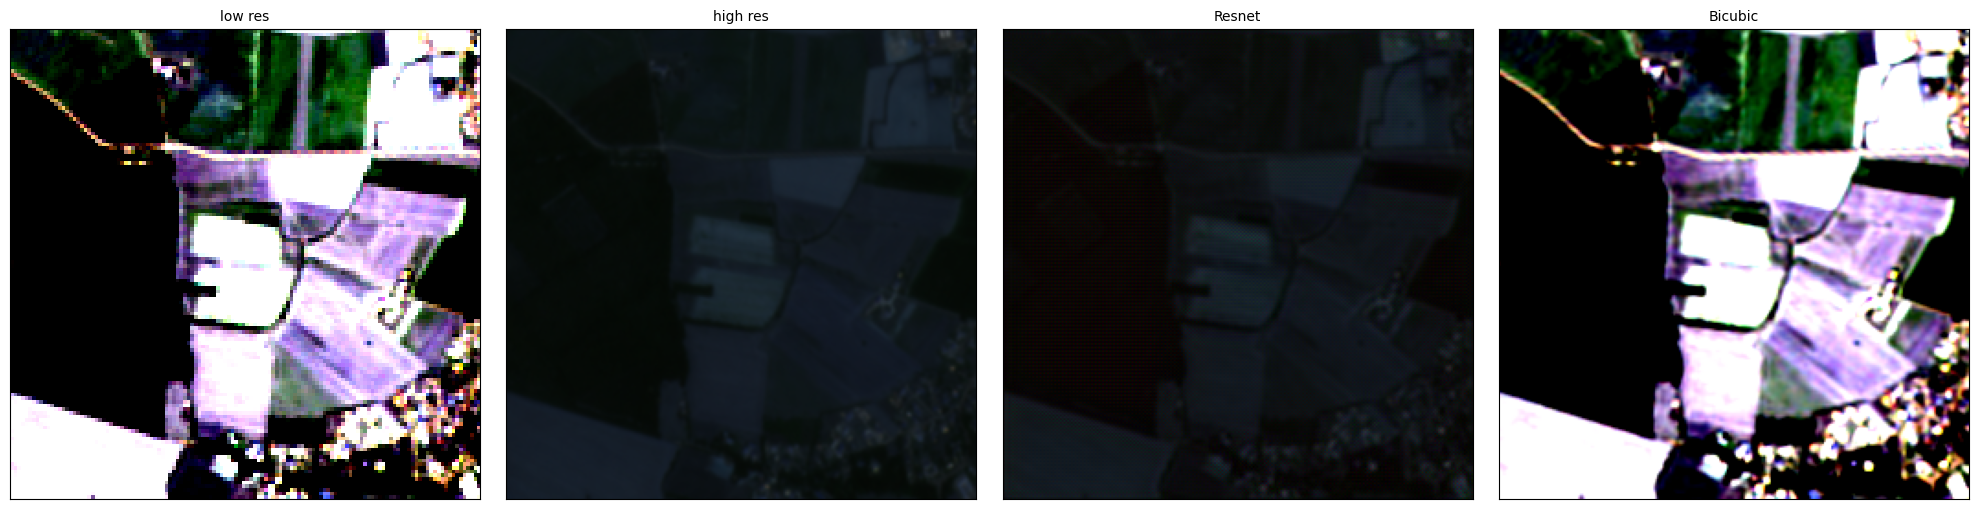

In [49]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
bicubic_out = interpolate(
    low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic"
).float()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
        bicubic_out[0].permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [1]:
print("hello world")

hello world
